In [70]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
import numpy as np
import matplotlib.pyplot as plt

device = "cuda:1" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda:1


In [1]:
model_name = "meta-llama/Meta-Llama-3-8B"  # e.g., "meta-llama/Llama-2-7b"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name, output_hidden_states=True)
model.eval()
if torch.cuda.is_available():
    model.to(device)

/data/common/ethanchang/ucct/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
The following generation flags are not valid and may be ignored: ['output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Loading checkpoint shards: 100%|██████████| 4/4 [00:02<00:00,  1.89it/s]


In [2]:
# for m in model.named_modules():
#     print(m)

Attached 32 hooks to layers 0 through 31.

Running a single forward pass to trigger all hooks...
Forward pass complete.
Removed all 32 hooks.

Calculating rho_d and d_r for each layer...
Calculations complete.


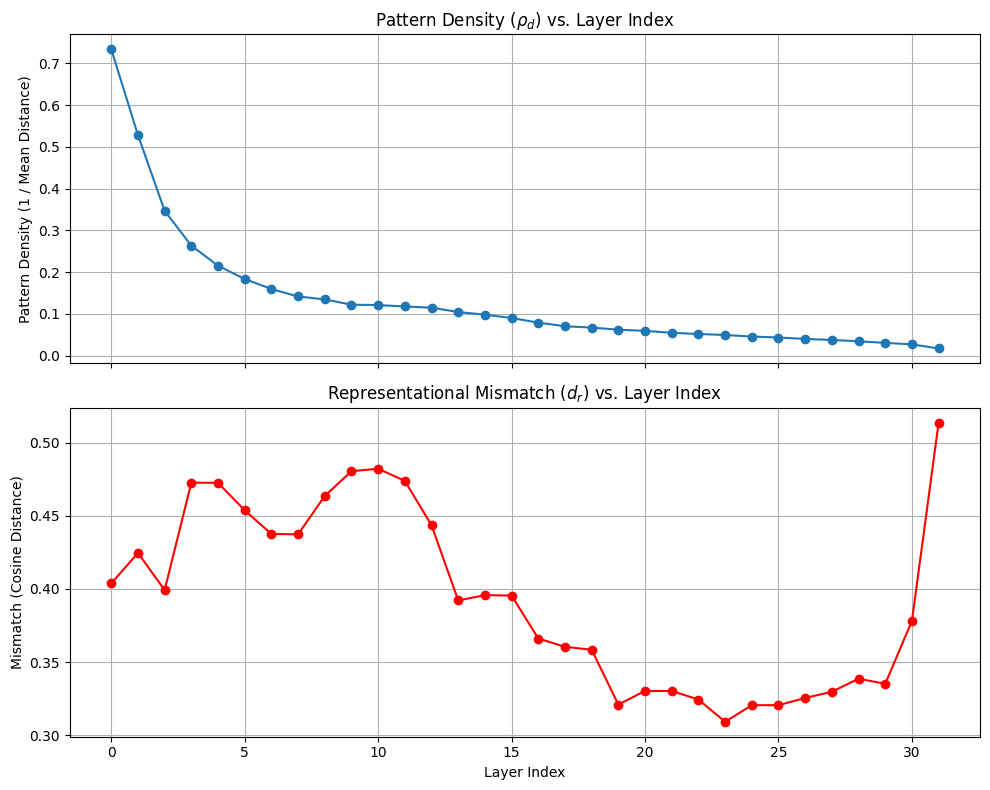

In [77]:
# A dictionary to store the output we want to capture
all_layer_outputs = {}

# Define a hook function
def get_layer_output_hook(layer_idx):
	def hook(module, input, output):
		# In PyTorch hooks, 'output' is what you want.
		# We detach it from the computation graph to save memory.
		all_layer_outputs[layer_idx] = output[0].detach()
	return hook

hook_handles = []
num_layers = len(model.model.layers) # Should be 32 for your model

for i in range(num_layers):
    target_layer = model.model.layers[i]
    handle = target_layer.register_forward_hook(get_layer_output_hook(i))
    hook_handles.append(handle)

print(f"Attached {len(hook_handles)} hooks to layers 0 through {num_layers-1}.")

task_instruction = "Translate from English to French."
anchor_examples = ["the cat is black -> le chat est noir", "the dog is white -> le chien est blanc"]
# Note: For a real experiment, you'd process each part of the anchor example separately
# to get the vector for 'cat', 'chat', 'dog', 'chien', etc. This is a simplification.

# For this example, let's just encode the whole anchor set at once
# In a real implementation, you'd get the specific token embeddings you need
text_to_process = [task_instruction] + anchor_examples
tokenizer.pad_token = tokenizer.eos_token  # Set padding token to EOS token
inputs = tokenizer(text_to_process, padding=True, return_tensors="pt").to(device)

print("\nRunning a single forward pass to trigger all hooks...")
with torch.no_grad():
    model(**inputs)
print("Forward pass complete.")

# --- Step 4: Clean Up the Hooks Immediately ---
for handle in hook_handles:
    handle.remove()
print(f"Removed all {len(hook_handles)} hooks.")

# --- Step 5: Process the Captured Data Layer by Layer ---
rho_d_by_layer = []
d_r_by_layer = []

print("\nCalculating rho_d and d_r for each layer...")
for i in range(num_layers):
    # Get the hidden states for this layer [batch_size, num_tokens, hidden_size]
    layer_hidden_states = all_layer_outputs[i]
    
    # Separate the representations
    # First item in batch is the task, the rest are examples
    task_vec = layer_hidden_states[0, -1, :] # Vector for last token of instruction
    example_vecs = layer_hidden_states[1:, -1, :] # Vectors for last token of each example

    # Calculate Pattern Density (rho_d)
    # Using torch.pdist for efficient pairwise distance calculation
    if len(example_vecs) > 1:
        pairwise_distances = torch.pdist(example_vecs)
        mean_dist = torch.mean(pairwise_distances)
        rho_d = 1 / (mean_dist + 1e-6) # Add epsilon for stability
    else:
        rho_d = 0 # Not defined for a single example
    rho_d_by_layer.append(rho_d.item())

    # Calculate Representational Mismatch (d_r)
    pattern_centroid = torch.mean(example_vecs, dim=0)
    # Cosine similarity is dot(a,b) / (norm(a)*norm(b))
    cos_sim = torch.nn.functional.cosine_similarity(task_vec, pattern_centroid, dim=0)
    d_r = 1 - cos_sim
    d_r_by_layer.append(d_r.item())

print("Calculations complete.")

# --- Step 6: Visualize the Results ---
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
layer_indices = list(range(num_layers))

# Plot Pattern Density
ax1.plot(layer_indices, rho_d_by_layer, marker='o', linestyle='-')
ax1.set_title('Pattern Density ($\\rho_d$) vs. Layer Index')
ax1.set_ylabel('Pattern Density (1 / Mean Distance)')
ax1.grid(True)

# Plot Representational Mismatch
ax2.plot(layer_indices, d_r_by_layer, marker='o', linestyle='-', color='r')
ax2.set_title('Representational Mismatch ($d_r$) vs. Layer Index')
ax2.set_ylabel('Mismatch (Cosine Distance)')
ax2.set_xlabel('Layer Index')
ax2.grid(True)

plt.tight_layout()
plt.show()



In [ ]:

# # Now, run a forward pass with your text
# # text = "The capital of France is:"
# text = "2 - 3 = 5\n7 - 4 = 11\n15 - 8 = 23\n 8 + 2 = 6. What is the pattern?\n The pattern is"
# inputs = tokenizer(text, return_tensors="pt").to(device)
# # if torch.cuda.is_available():
# # 	inputs = {k: v.to(device) for k, v in inputs.items()}

# outputs = model.generate(**inputs, max_new_tokens=50, return_dict_in_generate=True, output_scores=True)

# input_length = 1 if model.config.is_encoder_decoder else inputs.input_ids.shape[1]

# generated_tokens = outputs.sequences[:, input_length:]

# transition_scores = model.compute_transition_scores(

#     outputs.sequences, outputs.scores, normalize_logits=True

# )

# for tok, score in zip(generated_tokens[0].to('cpu'), transition_scores[0].to('cpu')):

#     # | token | token string | log probability | probability
#     print(f"| {tok:5d} | {tokenizer.decode(tok):8s} | {score.numpy():.3f} \t| {np.exp(score.numpy()):.2%}")
    
# # with torch.no_grad():
# #     out = model(**inputs)

# # The output is now in our dictionary
# # This is the vector you need for your encode() function
# encoded_vector = captured_outputs['hidden_state']

# # remove the hook to avoid memory leaks
# hook_handle.remove()

In [ ]:
# captured_outputs

{'hidden_state': tensor([[[-0.1591, -0.8908,  1.6972,  ..., -0.6135,  0.4216, -0.8188]]],
        device='cuda:1')}

In [56]:
# --- Step 1: Isolate the Logits for the NEXT Token ---
# The logits tensor has shape [batch_size, sequence_length, vocab_size]

# logits = out.logits
# print(f"Shape of logits: {logits.shape}")  # e.g., torch.Size([1, num_tokens, vocab_size])

# token_logits = logits[0, :, :]  # Get the logits all tokens in the sequence
# print(f"Shape of token logits: {token_logits.shape}")

# # --- decoding all logits ---
# for i, ls in enumerate(token_logits.topk(10).indices):
#     l = torch.argmax(ls)
#     print(f"Token ID: {l.item()} - Token: {tokenizer.decode(l)}")


# next_token_logits = logits[0, -1, :]
# print(f"Shape of logits for the next token: {next_token_logits.shape}")


# --- Step 2: Get the Token ID for all possible Next Tokens
# for l in next_token_logits.topk(10).indices:
# 	print(f"Token ID: {l.item()} - Token: {tokenizer.decode(l)}")


# # --- Step 2 (Method A): Greedy Decoding ---
# predicted_token_id_greedy = torch.argmax(next_token_logits)
# print(f"\nGreedy Method:")
# print(f"  Predicted Token ID: {predicted_token_id_greedy.item()}")

# # --- Step 3 (for Greedy): Decode the Token ID ---
# predicted_text_greedy = tokenizer.decode(predicted_token_id_greedy)
# print(f"  Decoded Text: '{predicted_text_greedy}'")
# print(f"  Full sentence: {text}{predicted_text_greedy}")

# # SAMPLING

# # --- Step 2 (Method B): Sampling ---
# # Apply softmax to convert logits to probabilities
# probabilities = torch.softmax(next_token_logits, dim=-1)
# # Sample a token from the distribution
# predicted_token_id_sampled = torch.multinomial(probabilities, num_samples=1)
# print(f"\nSampling Method:")
# print(f"  Predicted Token ID: {predicted_token_id_sampled.item()}")

# # --- Step 3 (for Sampling): Decode the Token ID ---
# predicted_text_sampled = tokenizer.decode(predicted_token_id_sampled.squeeze())
# print(f"  Decoded Text: '{predicted_text_sampled}'")
# print(f"  Full sentence: {text}{predicted_text_sampled}")


# # --- BONUS: The Easy Way with .generate() ---
# # The .generate() method does all of the above (and more) in a loop for you!
# print("\n--- Using the built-in .generate() method ---")
# # `.generate()` automatically handles the autoregressive loop, sampling, etc.
# # max_new_tokens controls how many new tokens to generate.
# generated_ids = model.generate(**inputs, max_new_tokens=5)
# generated_text = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)
# print(generated_text[0])

Shape of logits: torch.Size([1, 42, 128256])
Shape of token logits: torch.Size([42, 128256])
Token ID: 5 - Token: &
Token ID: 5 - Token: &
Token ID: 5 - Token: &
Token ID: 8 - Token: )
Token ID: 6 - Token: '
Token ID: 9 - Token: *
Token ID: 9 - Token: *
Token ID: 5 - Token: &
Token ID: 8 - Token: )
Token ID: 9 - Token: *
Token ID: 1 - Token: "
Token ID: 9 - Token: *
Token ID: 4 - Token: %
Token ID: 5 - Token: &
Token ID: 7 - Token: (
Token ID: 9 - Token: *
Token ID: 8 - Token: )
Token ID: 7 - Token: (
Token ID: 1 - Token: "
Token ID: 8 - Token: )
Token ID: 9 - Token: *
Token ID: 7 - Token: (
Token ID: 1 - Token: "
Token ID: 2 - Token: #
Token ID: 7 - Token: (
Token ID: 6 - Token: '
Token ID: 1 - Token: "
Token ID: 4 - Token: %
Token ID: 9 - Token: *
Token ID: 4 - Token: %
Token ID: 1 - Token: "
Token ID: 7 - Token: (
Token ID: 9 - Token: *
Token ID: 2 - Token: #
Token ID: 9 - Token: *
Token ID: 3 - Token: $
Token ID: 3 - Token: $
Token ID: 9 - Token: *
Token ID: 1 - Token: "
Token ID: 

# Starter Code

In [ ]:
import numpy as np


def get_embedding(text: str, layer_index: int, pool: str = "mean"):
    """
    Encode text and return embedding from specified layer.
    - layer_index: index into hidden_states; 0 is embedding output,
    1 is after first Transformer block, ..., model.config.num_hidden_layers for last
    .
    - pool: "mean" or "first".
    """
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
    if torch.cuda.is_available():
        inputs = {k: v.to("cuda") for k, v in inputs.items()}
    with torch.no_grad():
        out = model(**inputs)
        hidden_states = out.hidden_states
    hs = hidden_states[layer_index]  # (1, seq_len, hidden_size)
    hs = hs.squeeze(0)  # (seq_len, hidden_size)
    if pool == "mean":
        emb = hs.mean(dim=0)
    elif pool == "first":
        emb = hs[0]
    else:
        raise ValueError(f"Unknown pool type: {pool}")
    return emb.cpu().numpy()

In [5]:
from sklearn.neighbors import NearestNeighbors


def compute_rho_knn(pattern_embeddings: np.ndarray, k: int = 5, eps: float = 1e-8):
    """
	pattern_embeddings: (n_tasks, dim)
    Returns: rho array of shape (n_tasks,)
    """
    nbrs = NearestNeighbors(n_neighbors=k+1, algorithm="auto").fit(pattern_embeddings)
    distances, _ = nbrs.kneighbors(pattern_embeddings)
    dists = distances[:, 1:k+1] # exclude self
    avg = dists.mean(axis=1)
    rho = 1.0 / (avg + eps)
    return rho